# Fault Detection of APS Scania Trucks

Outline:

1. [Data Loading](#Data-Loading)
1. [Modeling](#Modeling)
1. [Evaluation](#Evaluation)

In [1]:
# Enable autoreloading
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             make_scorer,
                             precision_recall_curve,
                             plot_precision_recall_curve,
                             roc_auc_score)
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from urllib.parse import urljoin
from urllib.request import urlopen
from xgboost import XGBClassifier

from pmlib.evaluation.classical import aupr_score, auprg_score

In [3]:
N_JOBS = 32
RANDOM_STATE = 7

In [34]:
!mkdir -p ./images/scania/

# Data Loading

The data set consits of 76K rows and 171 columns.
Each row represent data about one APS Scania truck where:
 - column 'class' contains a binary variable whether a failure occured;
 - the rest of the columns represent 170 anonymized features.

The amount of positive classes in the data set is 1375 (1.81 % of total samples).

In [4]:
def load_aps_scania_trucks_data_set():

    base_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00421/'
    
    def load_data_csv(file_name):
        data = pd.read_csv(base_url + file_name, skiprows=20, na_values="na")
        data['class'] = data['class'].replace({'neg': 0, 'pos': 1}).astype(int)
        return data
    
    data_train = load_data_csv('aps_failure_training_set.csv')
    data_test = load_data_csv('aps_failure_test_set.csv')
    
    return data_train, data_test

In [5]:
data_train, data_test = load_aps_scania_trucks_data_set()

target_col = 'class'
feature_cols = data_train.drop(columns=[target_col]).columns

In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: float64(169), int64(2)
memory usage: 78.3 MB


In [7]:
data_train.sample(10)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
49065,0,1506,0.0,4.000000e+01,NaN,0.0,0.0,0.0,0.0,0.0,...,4390.0,2494.0,3916.0,5792.0,10112.0,35028.0,0.0,0.0,0.0,0.0
1132,0,39720,NaN,1.822000e+03,1566.0,0.0,0.0,0.0,0.0,0.0,...,429532.0,120786.0,359176.0,349902.0,245948.0,72538.0,22962.0,0.0,0.0,0.0
21283,0,29362,NaN,6.480000e+02,556.0,0.0,0.0,0.0,0.0,0.0,...,276058.0,141468.0,353396.0,266642.0,123330.0,56012.0,83014.0,19488.0,0.0,0.0
17742,0,38172,NaN,2.130706e+09,1018.0,0.0,0.0,0.0,0.0,0.0,...,309250.0,143244.0,267738.0,259446.0,199118.0,155488.0,275854.0,7960.0,0.0,0.0
20046,0,40184,NaN,1.320000e+02,70.0,0.0,0.0,0.0,0.0,0.0,...,209528.0,105550.0,231844.0,225810.0,263654.0,234894.0,421192.0,8274.0,0.0,0.0
40369,0,1748,NaN,1.580000e+02,132.0,0.0,0.0,0.0,0.0,0.0,...,4442.0,2114.0,10600.0,58740.0,1980.0,68.0,22.0,0.0,0.0,0.0
46673,0,80142,NaN,7.600000e+02,724.0,0.0,0.0,0.0,0.0,0.0,...,1047064.0,492698.0,968452.0,747270.0,474148.0,56622.0,352.0,0.0,0.0,0.0
40966,0,28,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,652.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54822,0,63204,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,584266.0,287170.0,546266.0,476306.0,341010.0,208564.0,301682.0,17056.0,0.0,0.0
57587,0,0,NaN,3.600000e+01,14.0,0.0,0.0,0.0,0.0,0.0,...,168.0,38.0,76.0,12.0,10.0,2.0,0.0,0.0,0.0,0.0


In [8]:
data_train.isna().sum().sort_values(ascending=False).head(10)

br_000    49264
bq_000    48722
bp_000    47740
bo_000    46333
cr_000    46329
ab_000    46329
bn_000    44009
bm_000    39549
bl_000    27277
bk_000    23034
dtype: int64

In [9]:
for df in [data_train, data_test]:
    samples = df.shape[0]
    pos = df["class"].sum()
    pos_pctg = np.round(100 * pos / samples, 2)

    print(f'Dataset size: {samples} samples')
    print(f'Positive classes: {pos} ({pos_pctg} %)')

Dataset size: 60000 samples
Positive classes: 1000 (1.67 %)
Dataset size: 16000 samples
Positive classes: 375 (2.34 %)


## Data Splitting

In [10]:
data_train_cv, data_train_val = train_test_split(data_train, test_size=0.2, stratify=data_train['class'], shuffle=True, random_state=RANDOM_STATE)

X_train, y_train = data_train_cv[feature_cols].values, data_train_cv['class'].values
X_val, y_val = data_train_val[feature_cols].values, data_train_val['class'].values
X_test, y_test = data_test[feature_cols].values, data_test['class'].values

## Candidate Models Selection

### Hyperparameter Search CV

Pipeline:
 - Imputing
 - PCA
 - balancing:
 
3 folds

Random search of 42 iterations

#### Pipeline

In [11]:
estimator = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('clf', XGBClassifier(random_state=10)),
])

param_grid = {
    'clf__max_depth': [2, 3, 4, 5, 6, 7],
    'clf__n_estimators': [4, 8, 16, 32, 64, 128, 256],
    'clf__learning_rate': [0.05, 0.1, 0.15, 0.2],
    'clf__booster': ['gbtree', 'dart'],
    'clf__min_child_weight': [ 1,  4, 16, 64],
    'clf__subsample': [0.6, 0.7, 0.8, 0.9, 1],
    'clf__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1]
}

#### Scorers

In [12]:
def f1_at_fpr(y_true, y_score, fpr=0.05):
    fprs, tprs, thresholds = roc_curve(y_true, y_score)
    threshold = np.interp(fpr, fprs, thresholds)
    y_pred = y_score >= threshold
    return fbeta_score(y_true, y_pred, beta=5)

def auc_at_fpr(y_true, y_score, fpr=0.05):
    fprs, tprs, thresholds = roc_curve(y_true, y_score)
    threshold = np.interp(fpr, fprs, thresholds)
    mask = thresholds <= threshold
    return auc(fprs[mask], tprs[mask])


scorers = {
    'auprg': make_scorer(auprg_score, needs_proba=True),
    'f1': make_scorer(f1_score),
    'accuracy': make_scorer(accuracy_score),
    'auroc': make_scorer(roc_auc_score, needs_proba=True),
}

#### Run

In [ ]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

search_pipeline = RandomizedSearchCV(estimator, param_grid,
                                     scoring=scorers,
                                     n_jobs=N_JOBS,
                                     verbose=10,
                                     cv=cv,
                                     refit=False,
                                     n_iter=N_JOBS*5,
                                     random_state=RANDOM_STATE
                                    )

search_pipeline.fit(X_train, y_train)

Fitting 10 folds for each of 160 candidates, totalling 1600 fits


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    8.1s
[Parallel(n_jobs=32)]: Done  21 tasks      | elapsed:  1.0min
[Parallel(n_jobs=32)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=32)]: Done  49 tasks      | elapsed:  2.4min
[Parallel(n_jobs=32)]: Done  64 tasks      | elapsed:  2.9min
[Parallel(n_jobs=32)]: Done  81 tasks      | elapsed:  3.3min
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:  3.4min
[Parallel(n_jobs=32)]: Done 117 tasks      | elapsed:  3.6min
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:  4.0min
[Parallel(n_jobs=32)]: Done 157 tasks      | elapsed:  5.0min
[Parallel(n_jobs=32)]: Done 178 tasks      | elapsed:  5.3min
[Parallel(n_jobs=32)]: Done 201 tasks      | elapsed:  5.6min
[Parallel(n_jobs=32)]: Done 224 tasks      | elapsed:  6.0min
[Parallel(n_jobs=32)]: Done 249 tasks      | elapsed:  6.9min
[Parallel(n_jobs=32)]: Done 274 tasks      | elapsed:  

### Analyze Results and Select Candidate Models

In [21]:
cv_results = pd.DataFrame(search_pipeline.cv_results_)
cv_results['param_clf__max_depth'] = cv_results['param_clf__max_depth'].astype(int)
cv_results['param_clf__n_estimators'] = cv_results['param_clf__n_estimators'].astype(int)

#### Correlation Between Ranks of Models by Metrics

In [22]:
cv_results.sort_values('mean_fit_time', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__subsample,param_clf__n_estimators,param_clf__min_child_weight,param_clf__max_depth,param_clf__learning_rate,param_clf__colsample_bytree,...,split3_test_auroc,split4_test_auroc,split5_test_auroc,split6_test_auroc,split7_test_auroc,split8_test_auroc,split9_test_auroc,mean_test_auroc,std_test_auroc,rank_test_auroc
87,367.760865,7.643969,0.422910,0.017098,0.7,256,1,6,0.05,0.9,...,0.988504,0.990606,0.975614,0.984407,0.991503,0.991266,0.980977,0.988824,0.006445,34
140,345.983238,6.137372,0.362852,0.009952,0.8,256,1,7,0.2,0.9,...,0.989166,0.991647,0.974203,0.983377,0.988840,0.990318,0.981727,0.988216,0.006537,49
32,255.384220,5.941153,0.369802,0.013007,0.7,256,16,7,0.05,0.7,...,0.990956,0.986157,0.981123,0.984619,0.992068,0.991555,0.986798,0.989584,0.004790,15
33,245.625970,4.032555,0.382764,0.019302,0.9,256,16,5,0.1,0.7,...,0.993186,0.990747,0.983440,0.984031,0.992428,0.988599,0.988257,0.990641,0.004438,1
73,230.179536,4.066043,0.348096,0.020181,1,256,4,4,0.05,0.7,...,0.989878,0.988260,0.982023,0.986438,0.992570,0.991970,0.981920,0.989739,0.004912,12


In [23]:
param_cols = cv_results.columns[cv_results.columns.str.startswith('param_')]
mean_test_cols = cv_results.columns[cv_results.columns.str.startswith('mean_test_')]
rank_test_cols = cv_results.columns[cv_results.columns.str.startswith('rank_test_')]

In [24]:
for metric in ['f1', 'auroc']:
    print(f'Metric: {metric}')
    print(f'Params: {cv_results.sort_values(f"mean_test_{metric}").iloc[-1][param_cols].to_dict()}')

Metric: f1
Params: {'param_clf__subsample': 0.8, 'param_clf__n_estimators': 256, 'param_clf__min_child_weight': 1, 'param_clf__max_depth': 7, 'param_clf__learning_rate': 0.2, 'param_clf__colsample_bytree': 0.9, 'param_clf__booster': 'dart'}
Metric: auroc
Params: {'param_clf__subsample': 0.9, 'param_clf__n_estimators': 256, 'param_clf__min_child_weight': 16, 'param_clf__max_depth': 5, 'param_clf__learning_rate': 0.1, 'param_clf__colsample_bytree': 0.7, 'param_clf__booster': 'dart'}


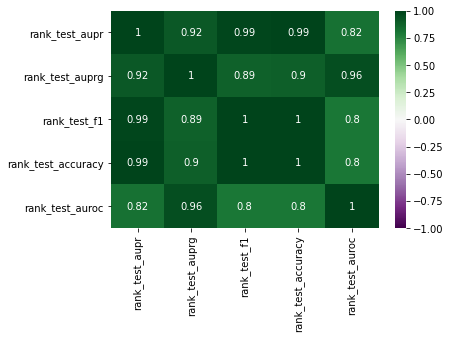

In [25]:
df = cv_results

sns.heatmap(df[rank_test_cols].corr(), annot=True, cmap='PRGn', vmin=-1, vmax=1)

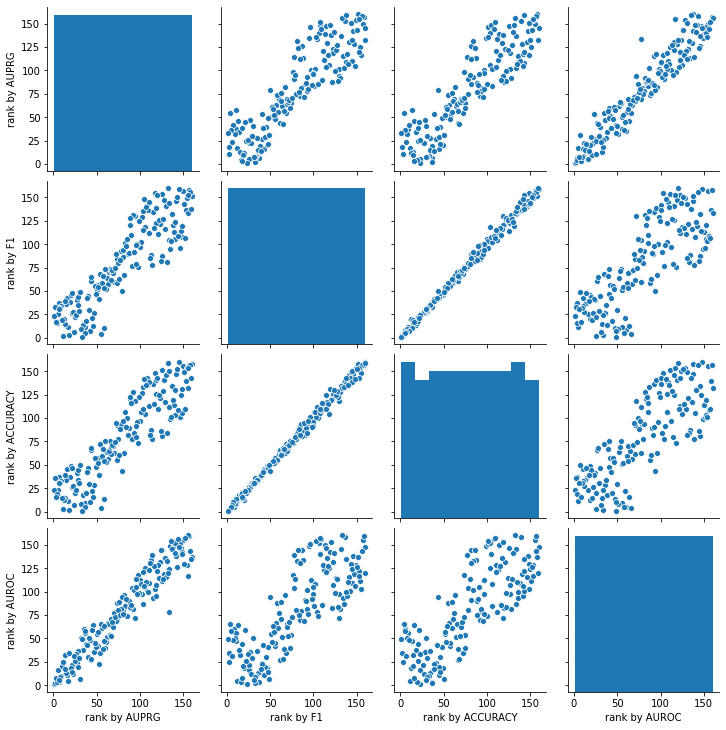

In [26]:
df = cv_results[rank_test_cols].drop(columns=['rank_test_aupr']).copy()
df = df.rename(columns={s: f'rank by {s.upper()[10:]}' for s in df.columns if s != 'accuracy'})
sns.pairplot(df)
plt.savefig('./images/scania/experiments_fault_detection_aps_pairplot.pdf', bbox_inches='tight')

In [30]:
import string

df = (
    cv_results
    .copy()
    .loc[lambda df: df[rank_test_cols].min(axis=1).le(1),
         [*rank_test_cols, *param_cols, *mean_test_cols]]
    .reset_index(drop=True)
)
df[mean_test_cols] = df[mean_test_cols].astype(float).round(10)
df = df.rename(columns={s: f'rank by {s.upper()[10:]}' for s in rank_test_cols})
df = df.rename(columns={s: f'{s.upper()[10:]}' for s in mean_test_cols})
df = df.T
df.columns = list(string.ascii_uppercase[:df.columns.shape[0]])
df.to_latex('./images/scania/candidate_models.tex')
display(df)

selected_models_parameters = df

,A,B,C
rank by AUPR,20,1,2
rank by AUPRG,1,18,33
rank by F1,23,3,1
rank by ACCURACY,23,2,1
rank by AUROC,1,34,49
param_clf__subsample,0.9,0.7,0.8
param_clf__n_estimators,256,256,256
param_clf__min_child_weight,16,1,1
param_clf__max_depth,5,6,7
param_clf__learning_rate,0.1,0.05,0.2


In [31]:
models = dict()
for metric in ['auroc', 'f1']:
    df = cv_results.loc[cv_results[f'rank_test_{metric}'].eq(1), param_cols]
    df.columns = df.columns.str[11:]
    model_params = df.iloc[0].to_dict()
    model = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('clf', XGBClassifier(**model_params, n_jobs=N_JOBS, random_state=RANDOM_STATE)),
    ])
    model.fit(X_train, y_train)
    models[metric] = model
models

{'auroc': Pipeline(memory=None,
          steps=[('imputer',
                  SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                                missing_values=nan, strategy='mean',
                                verbose=0)),
                 ('clf',
                  XGBClassifier(base_score=0.5, booster='dart',
                                colsample_bylevel=1, colsample_bynode=1,
                                colsample_bytree=0.7, gamma=0, gpu_id=-1,
                                importance_type='gain',
                                interaction_constraints=None, learning_rate=0.1,
                                max_delta_step=0, max_depth=5,
                                min_child_weight=16, missing=nan,
                                monotone_constraints=None, n_estimators=256,
                                n_jobs=32, num_parallel_tree=1,
                                objective='binary:logistic', random_state=7,
                        

## Final Model and Decision Threshold Selection

From the domain, we have a cost function for FPs and FNs:
  - \\$10 per FP
  - \\$500 per FN
 
The goal is to minimize the costs. Therefore, we select the threshold where the minimal cost is.

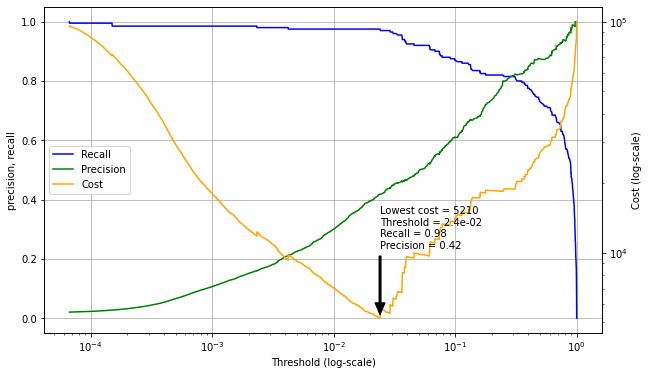

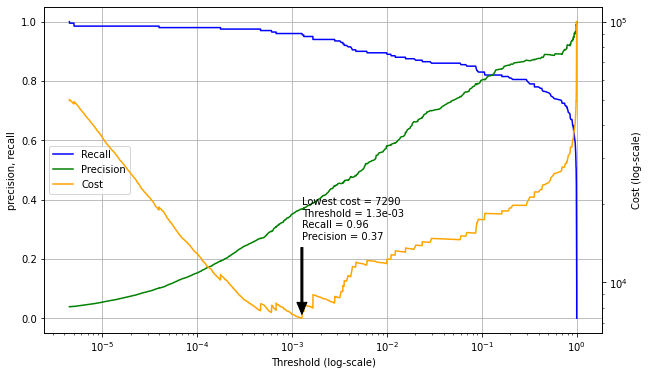

In [32]:
def plot_precision_recall_costs(y_true, y_proba,
                                fp_cost=10, fn_cost=500,
                                log_scale_threshold=True,
                                log_scale_cost=True
                               ):
    
    def cost_function(y_true, y_pred):
        fp = np.sum((y_true - y_pred) == -1)
        fn = np.sum((y_true - y_pred) == 1)
        return (fp * fp_cost + fn * fn_cost).astype(int)
    
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    thresholds = np.r_[thresholds, 1]

    costs = []
    fps = []
    fns = []
    
    for threshold in thresholds:
        y_pred = y_proba >= threshold
        fp = np.sum((y_true - y_pred) == -1)
        fn = np.sum((y_true - y_pred) == 1)
        costs.append(cost_function(y_true, y_pred))

    best_index = np.argmin(costs)
    threshold = thresholds[best_index]
    cost = np.round(costs[best_index], 2)
    precision = np.round(precisions[best_index], 2)
    recall = np.round(recalls[best_index], 2)
    f1 = np.round(2*precision*recall / (precision + recall), 2)
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    xlabel = 'Threshold'
    if log_scale_threshold:
        xlabel += ' (log-scale)'
        plt.xscale('log')
    plt.xlabel(xlabel)

    lns1 = ax1.plot(thresholds, recalls, color='blue', label='Recall')
    lns2 = ax1.plot(thresholds, precisions, color='green', label='Precision')
    
    ax2 = ax1.twinx()
    lns4 = ax2.plot(thresholds, costs, color='orange', label='Cost')    
    cost_label = 'Cost'
    if log_scale_cost:
        ax2.set_yscale('log')
        cost_label += ' (log-scale)'
    ax2.set_ylabel(cost_label)
    
    # Annotate
    ax2.annotate(xy=(threshold, cost),
                 xytext=(threshold, cost*2),
                 arrowprops=dict(
                     facecolor='black',
                     shrink=0.05,
                     headwidth=10,
                     width=2,
                 ),
                 s=f'Lowest cost = {cost}\n'
                   f'Threshold = {threshold:.1e}\n'
                   f'Recall = {recall}\n'
                   f'Precision = {precision}'
            )
    ax1.set_ylabel('precision, recall')
    
    lns = lns1+lns2+lns4
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0)
    ax1.grid()
    return costs, thresholds, precisions, recalls

for metric in ['auroc', 'f1']:
    y_score = models[metric].predict_proba(X_val)[:, 1]
    costs, thresholds, precisions, recalls = \
        plot_precision_recall_costs(y_val, y_score, log_scale_threshold=True)
    best_threshold = thresholds[np.argmin(costs)]
    plt.savefig(f'./images/scania/experiments_fault_detection_aps_cost_threshold_{metric}.pdf', bbox_inches='tight')

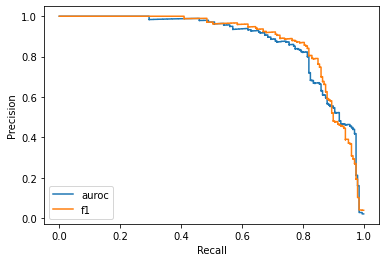

In [35]:
fig, ax = plt.subplots()
for metric in ['auroc', 'f1']:
    plot_precision_recall_curve(models[metric], X_val, y_val, ax=ax, label=metric)

## Final Model Evaluation

Evaluation on the test set.

In [ ]:
def cost_function(y_true, y_pred):
    fp = np.sum((y_true - y_pred) == -1)
    fn = np.sum((y_true - y_pred) == 1)
    return (fp * 10 + fn * 500).astype(int)

y_test_pred = models['auroc'].predict_proba(X_test)[:, 1] >= best_threshold

print(f'Accuracy: {np.round(accuracy_score(y_test, y_test_pred), 2)}')
print(f'Recall: {np.round(recall_score(y_test, y_test_pred), 2)}')
print(f'Precision: {np.round(precision_score(y_test, y_test_pred), 2)}')
print(f'F1 score: {np.round(f1_score(y_test, y_test_pred), 2)}')
print(f'Cost: {np.round(cost_function(y_test, y_test_pred), 2)}')